In [2]:
!pip install --upgrade tf-keras

In [3]:
import torch
import transformers
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

print("Transformers OK:", transformers.__version__)
print("Torch GPU:", torch.cuda.is_available())

Transformers OK: 4.51.3
Torch GPU: False


In [4]:
# 1) Install & restart kernel
!pip install --upgrade transformers datasets torch

# 2) Imports
import torch
from transformers import DistilBertTokenizerFast

# 3) Instantiate
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# 4) Quick test
print(tokenizer("Swipe transaction at Vista, CA for $20.00"))

{'input_ids': [101, 25430, 15457, 12598, 2012, 13005, 1010, 6187, 2005, 1002, 2322, 1012, 4002, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [5]:
# 1. Install / upgrade everything you need
!pip install --upgrade transformers datasets torch scikit-learn pandas matplotlib seaborn
!pip install tf-keras

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
import os
import re
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

# 3) (Optional) check versions & device
print("HF Transformers:", transformers.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

HF Transformers: 4.51.3
Running on cpu


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
# Adjust path if needed
df = pd.read_csv("/Users/jay/Desktop/Smart-Transaction-Categorization/transactions_data.csv")  
print(df.shape)
print(df.columns.tolist())
df.head()

(13305915, 12)
['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors']


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


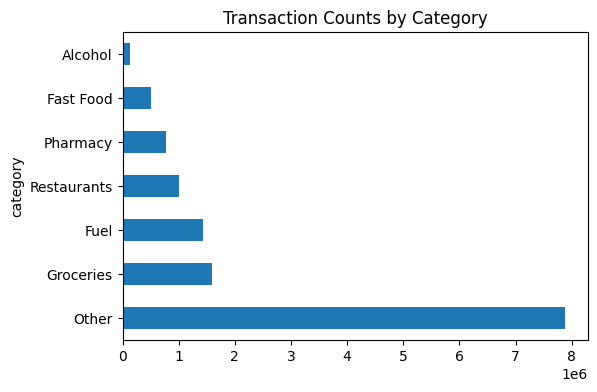

In [8]:
# Example MCC mapping (extend as you like)
mcc_map = {
    5411: 'Groceries', 5541: 'Fuel', 5812: 'Restaurants',
    5814: 'Fast Food', 5912: 'Pharmacy', 5921: 'Alcohol',
    5944: 'Jewelry', 5999: 'Misc Retail', 6536: 'Money Transfer',
    6011: 'ATM'
}

df['mcc'] = pd.to_numeric(df['mcc'], errors='coerce')
df['category'] = df['mcc'].map(mcc_map).fillna('Other')
df['category'].value_counts().plot.barh(figsize=(6,4))
plt.title("Transaction Counts by Category")
plt.show()

In [9]:
# 5a. Synthetic description
df['description'] = (
    df['use_chip'].astype(str) + " at " +
    df['merchant_city'].astype(str) + ", " +
    df['merchant_state'].astype(str) +
    " for $" + df['amount'].astype(str)
)

# 5b. Cleaning
def clean_text(text):
    return re.sub(r"[^\w\s\$]", "", str(text).lower())

df['clean_description'] = df['description'].apply(clean_text)

# Quick sanity check
df[['description','clean_description']].iloc[0:3]

,description,clean_description
0,"Swipe Transaction at Beulah, ND for $$-77.00",swipe transaction at beulah nd for $$7700
1,"Swipe Transaction at Bettendorf, IA for $$14.57",swipe transaction at bettendorf ia for $$1457
2,"Swipe Transaction at Vista, CA for $$80.00",swipe transaction at vista ca for $$8000


In [10]:
# Limit to 5k samples per category
df_small = (
    df.groupby('category', group_keys=False)
      .apply(lambda g: g.sample(n=min(len(g), 5000), random_state=42))
)

print("Down-sampled shape:", df_small.shape)

Down-sampled shape: (35000, 15)


/var/folders/28/g1cg9rnn7f5f5jk_39vbmj9h0000gn/T/ipykernel_9703/3677043186.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), 5000), random_state=42))


In [11]:
texts  = df_small['clean_description'].tolist()
labels = df_small['category'].tolist()

le = pd.factorize(labels)[1]  # get category names
label_encoder = {cat: idx for idx, cat in enumerate(le)}
label_ids     = [label_encoder[c] for c in labels]

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, label_ids,
    test_size=0.2,
    random_state=42,
    stratify=label_ids
)

print("Train / Val sizes:", len(train_texts), len(val_texts))

Train / Val sizes: 28000 7000


/var/folders/28/g1cg9rnn7f5f5jk_39vbmj9h0000gn/T/ipykernel_9703/2718794227.py:4: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  le = pd.factorize(labels)[1]  # get category names


In [12]:
!pip install tokenizer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

class LazyDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, max_len=64):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_ds = LazyDataset(train_texts, train_labels)
val_ds   = LazyDataset(val_texts,   val_labels)

In [14]:
!pip install --upgrade transformers[torch] accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
import torch
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

print("Transformers:", transformers.__version__)
print("Accelerate:", __import__("accelerate").__version__)
print("GPU available?", torch.cuda.is_available())

Transformers: 4.51.3
Accelerate: 1.7.0
GPU available? False


In [42]:
import torch
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

# 1) Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# 2) Lazy dataset definition (if you used it)
class LazyDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, max_len=64):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# 3) (Re)create your train_ds and val_ds from your lists:
#    Make sure train_texts, train_labels, val_texts, val_labels exist in this session.
train_ds = LazyDataset(train_texts, train_labels)
val_ds   = LazyDataset(val_texts,   val_labels)

# 4) Load the model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(le)   # `le` = your list/array of categories
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 5) Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
)

# 6) Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
)

# 7) Start training
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,1.950300
100,1.940800
150,1.854300
200,1.881200
250,1.804500
300,1.843200
350,1.803000
400,1.829400
450,1.795900
500,1.787100


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=21000, training_loss=1.635373528616769, metrics={'train_runtime': 2607.9222, 'train_samples_per_second': 32.21, 'train_steps_per_second': 8.052, 'total_flos': 1391031710208000.0, 'train_loss': 1.635373528616769, 'epoch': 3.0})

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation Metrics: {'eval_loss': 1.6082758903503418, 'eval_model_preparation_time': 0.0005, 'eval_runtime': 24.8832, 'eval_samples_per_second': 281.314, 'eval_steps_per_second': 70.329}

Classification Report:
              precision    recall  f1-score   support

     Alcohol       0.46      0.68      0.55      1000
   Fast Food       0.26      0.22      0.24      1000
        Fuel       0.83      0.39      0.53      1000
   Groceries       0.22      0.30      0.25      1000
       Other       0.82      0.31      0.45      1000
    Pharmacy       0.27      0.44      0.34      1000
 Restaurants       0.23      0.19      0.21      1000

    accuracy                           0.36      7000
   macro avg       0.44      0.36      0.37      7000
weighted avg       0.44      0.36      0.37      7000



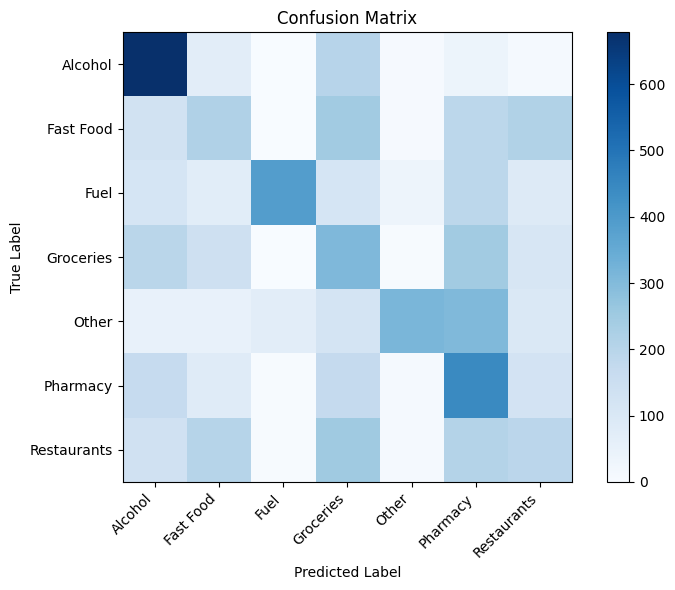

,Text,True,Predicted
0,chip transaction at duluth mn for $$134,Fast Food,Groceries
1,swipe transaction at southgate mi for $$14980,Groceries,Pharmacy
2,swipe transaction at coldwater mi for $$1085,Restaurants,Fast Food
3,swipe transaction at ewa beach hi for $$1874,Pharmacy,Groceries
4,chip transaction at lamont fl for $$1647,Alcohol,Fast Food
5,swipe transaction at manchester nh for $$4556,Fast Food,Restaurants
6,chip transaction at durham nc for $$3980,Restaurants,Pharmacy
7,swipe transaction at dinuba ca for $$530,Groceries,Pharmacy
8,swipe transaction at wickes ar for $$1153,Groceries,Alcohol
9,swipe transaction at catonsville md for $$2591,Other,Pharmacy


In [44]:
 # 1) Re-import essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import Trainer

# 2) Recreate the trainer (assuming model, train_ds, val_ds, training_args are defined)
#    If not, you may need to re-run the cell that defines tokenizer, LazyDataset, train_ds, val_ds, model, training_args
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
)

# 3) Evaluate & predict
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

pred_output = trainer.predict(val_ds)
preds = np.argmax(pred_output.predictions, axis=1)

# 4) Classification report
print("\nClassification Report:")
print(classification_report(val_labels, preds, target_names=list(le)))

# 5) Confusion matrix plot
cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(le)), le, rotation=45, ha='right')
plt.yticks(np.arange(len(le)), le)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# 6) Show top 10 misclassifications
mis = [
    (text, le[true], le[pred]) 
    for text, true, pred in zip(val_texts, val_labels, preds) 
    if true != pred
][:10]
pd.DataFrame(mis, columns=["Text","True","Predicted"])